In [1]:
%%time
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
import pandas as pd
import numpy as np
import scipy.io.wavfile
from scipy import fftpack

import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline

from os import sep
from os.path import isfile, join, abspath, expanduser
import platform

from moviepy.editor import AudioFileClip, VideoFileClip

from sklearn.decomposition import PCA
from sklearn.externals import joblib
from ggplot import *

CPU times: user 1.09 s, sys: 259 ms, total: 1.35 s
Wall time: 1.71 s


In [2]:
#home = expanduser("~")
dirpath = join(abspath(sep),'Users/brianschneider/Desktop/capstone/gameSummarizer')
file_basename = 'trainingData'
eventFileName = join(dirpath, file_basename+'.csv')
event_data = pd.read_csv(eventFileName, sep=',',header=0)
print(len(event_data),' events loaded')


356  events loaded


In [3]:
# Compute offset of each clip in the new clips collection and add to DataFrame
offset=np.cumsum(event_data["timeToCapture"])
event_data["offset"]=offset-event_data["timeToCapture"]
# Prepare a list of labels
labels=[row["eventName"] 
        for index,row in event_data.iterrows() 
        for i in np.arange(row["offset"],row["offset"]+row["timeToCapture"])]

# Build a sound array from training data and perform FFT

In [4]:
%%time
F = []
samprate = 44100
for index, row in event_data.iterrows():
    #print row['secondOffset'], row['timeToCapture']
    videoFileName = join(dirpath, row['fileName'])
    if isfile(videoFileName):
        audioClip = AudioFileClip(videoFileName).subclip(row['secondOffset'],row['secondOffset']+row['timeToCapture'])
        wavClip = audioClip.to_soundarray(fps=samprate)
        wavdata = wavClip.reshape(-1, samprate,  2)
        dims = wavdata.shape
        for sec in np.arange(dims[0]):
            ch1 = scipy.fftpack.fft(wavdata[sec,:,0])[:samprate//2] # Left channel
            ch2 = scipy.fftpack.fft(wavdata[sec,:,1])[:samprate//2] # Right channel
            ch = np.vstack([ch1,ch2])
            F.append(ch)
        del audioClip
    else:
        print('Could not find file ', videoFileName)

F = np.absolute(F)/samprate
F_db = 20*np.log10(2*F)  # Dimensions are (seconds, channels, samples)
f = scipy.fftpack.fftfreq(samprate, 1.0/samprate)[:samprate//2]

CPU times: user 16.4 s, sys: 9.96 s, total: 26.4 s
Wall time: 1min 21s


# Play a video clip

In [5]:
# def getClip(path,offset,length):
#     videoClip = VideoFileClip(path).subclip(offset,offset+length)
#     print('Playing {0}, offset={1}, length={2}'.format(path,offset,length))
#     return videoClip

# def getEvent(eventNumber):
#     offset=int(event_data.iloc[eventNumber-1]["secondOffset"])
#     length=int(event_data.iloc[eventNumber-1]["timeToCapture"])
#     path=join(dirpath, event_data.iloc[eventNumber-1]["fileName"])
#     videoClip = VideoFileClip(path).subclip(offset,offset+length)
#     print('Playing {0}, offset={1}, length={2}'.format(path,offset,length))
#     return videoClip

Play an event number from event file (first event is #1 which is in line #2 in the file)

In [6]:
# clip = getEvent(2)  
# clip.ipython_display(width=480, autoplay=True) 

Play a portion of a clip using offset and length in seconds 

# Plot frequency vs. amplitude

In [7]:
def plotFrequencySpectrum(second):
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 3, 3)
    plt.plot(f,np.transpose(F_db[second-1,:,:]), alpha=0.5)
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude(in dB)')
    plt.subplot(1, 3, 2)
    plt.plot(f,np.transpose(F[second-1,:,:]), alpha=0.4)
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.subplot(1, 3, 1)
    plt.plot(wavdata[second-1,:,], alpha=0.4)
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.show()

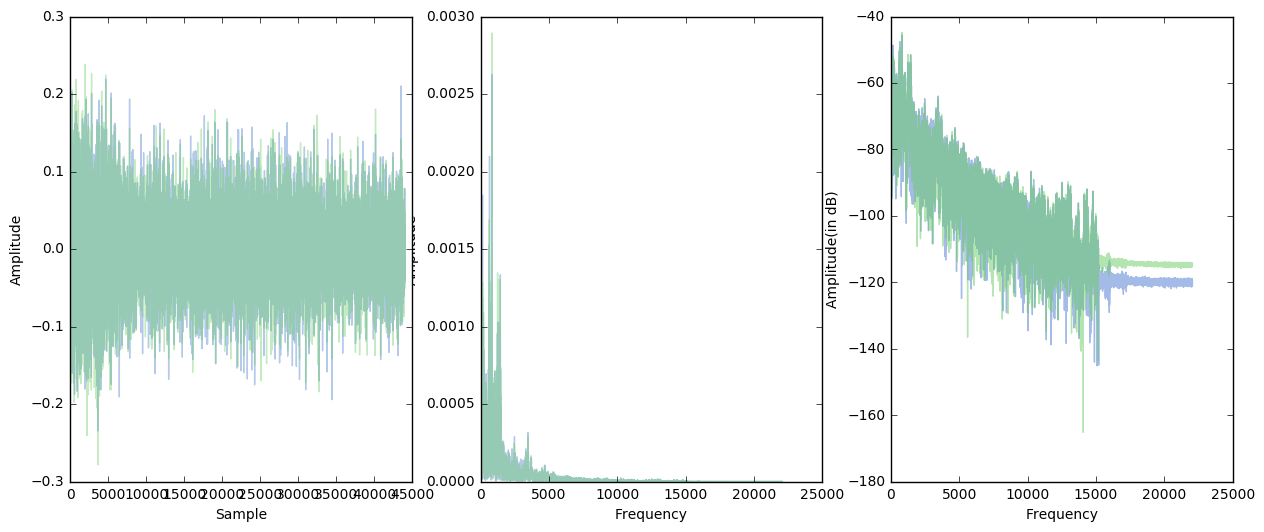

In [8]:
plotFrequencySpectrum(2)

# Dimentionality reduction: PCA

In [9]:
# a handy function for vizualizing principle components as a heatmap
# this allows you to see what dimensions in the 'original space' are
# active

def visualize_pca_comps_heatmap(plot, comps):
    heatmap = plot.pcolor(comps, cmap=plt.cm.Blues)
    
    x_lab = [i for i in range(comps.shape[1])]
    y_lab = [i for i in (range(comps.shape[0]))]
    
    plot.set_xticks(np.arange(comps.shape[1])+0.5, minor=False)
    plot.set_yticks(np.arange(comps.shape[0])+0.5, minor=False)
    
    # want a more natural, table-like display
    plot.invert_yaxis()
    
    plot.set_xticklabels(x_lab, minor=False)
    plot.set_yticklabels(y_lab, minor=False)
    
    plt.title('Heatmap of PCA components Rows: components, Cols: Original dimensions')

In [10]:
print (F_db.shape)
F2 = F.reshape(F_db.shape[0],-1)
print (F2.shape)

(2486, 2, 22050)
(2486, 44100)


Explained variance ratio: 
 [ 0.00062505  0.00061751  0.0006168   0.00061272  0.00060398  0.00059965
  0.0005976   0.00059303  0.00058834  0.0005845   0.00057638  0.00057597
  0.00057462  0.00056747  0.00056424  0.00056053  0.00055536  0.00054858
  0.00054615  0.00054489]
Explained variance ratio: 
 (170,)
Cumulative explained variance: 
 [ 0.7687616   0.7693791   0.7699959   0.77060863  0.77121261  0.77181226
  0.77240986  0.77300289  0.77359123  0.77417573  0.77475211  0.77532808
  0.7759027   0.77647016  0.7770344   0.77759493  0.77815029  0.77869888
  0.77924502  0.77978991]
PCA components: 
 (170, 44100)
CPU times: user 57.9 s, sys: 2.69 s, total: 1min
Wall time: 12.7 s


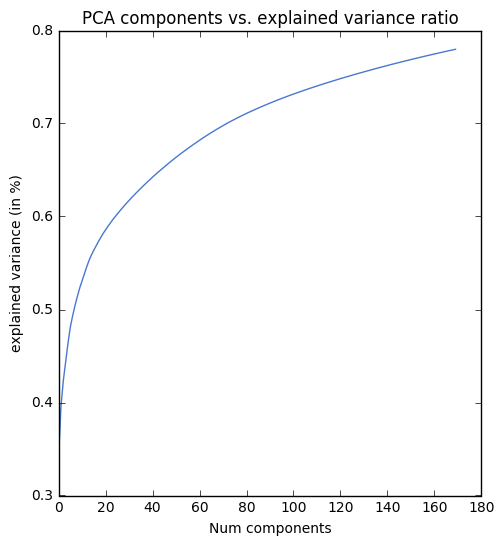

In [11]:
%%time
n_components = 170
pca_model = PCA(n_components)
pca_model.fit(F2)
joblib.dump(pca_model, 'model_pca.pkl', protocol=2) 
print('Explained variance ratio: \n', pca_model.explained_variance_ratio_[-20:])
print('Explained variance ratio: \n', pca_model.explained_variance_ratio_.shape)
print('Cumulative explained variance: \n', np.cumsum(pca_model.explained_variance_ratio_)[-20:])
print('PCA components: \n', pca_model.components_.shape)

plt.figure(figsize=(12, 6))
#p2 = plt.subplot(1, 2, 1)
#visualize_pca_comps_heatmap(p2, model.components_)
plt.subplot(1, 2, 2)
plt.plot(np.cumsum(pca_model.explained_variance_ratio_))
plt.xlabel('Num components')
plt.ylabel('explained variance (in %)')
plt.title('PCA components vs. explained variance ratio')

In [12]:
# Apply PCA Transformation to the input to create embeddings

In [13]:
%%time
print(F2.shape)
t= pca_model.transform(F2)
print(t.shape)

(2486, 44100)
(2486, 170)
CPU times: user 3.58 s, sys: 345 ms, total: 3.93 s
Wall time: 1.1 s


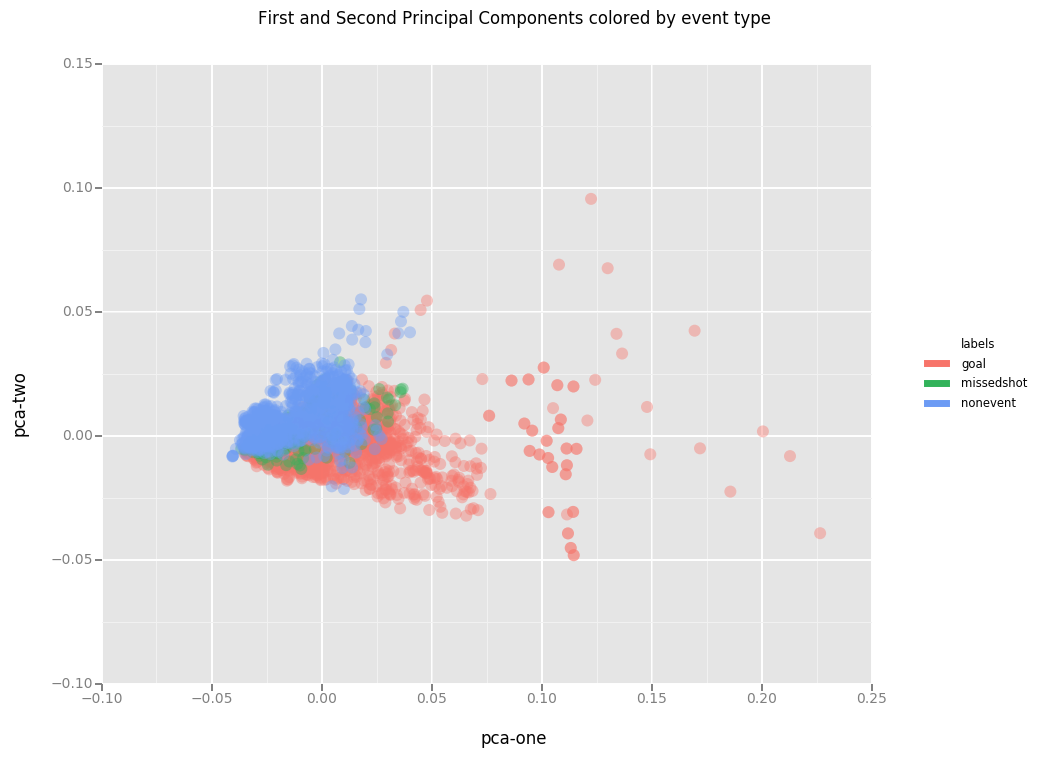

<ggplot: (288697783)>

In [14]:
df_pca = pd.DataFrame(t[:,0], columns=["pca-one"])
df_pca["pca-two"] = t[:,1]
df_pca["labels"] = labels


chart = ggplot( df_pca, aes(x='pca-one', y='pca-two', color='labels') ) \
        + geom_point(size=75,alpha=0.4) \
        + ggtitle("First and Second Principal Components colored by event type")
chart

## Try tSNE
Use the reduced dimensions as were produced by PCA (to improve performance)

In [15]:
# %%time
# from sklearn.manifold import TSNE
# tsne = TSNE(n_components=2, verbose=1, perplexity=160, n_iter=1200, learning_rate=25)
# tsne_results = tsne.fit_transform(t)

In [16]:
# df_tsne = pd.DataFrame(tsne_results[:,0], columns=["x-tsne"])
# df_tsne["y-tsne"] = tsne_results[:,1]
# df_tsne["labels"] = labels

In [17]:
# chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='labels') ) \
#         + geom_point(size=70,alpha=0.5) \
#         + ggtitle("tSNE dimensions colored by event type")
# chart

##  Try truncated SVD

In [18]:
# from sklearn.decomposition import TruncatedSVD
# svd = TruncatedSVD(n_components=n_components, n_iter=17, random_state=42)
# svd_results = svd.fit_transform(F2)
# print(svd.explained_variance_ratio_) 
# print(svd.explained_variance_ratio_.sum()) 

In [19]:
# df_svd = pd.DataFrame(svd_results[:,0], columns=["svd-one"])
# df_svd["svd-two"] = svd_results[:,1]
# df_svd["labels"] = labels


# chart = ggplot( df_svd, aes(x='svd-one', y='svd-two', color='labels') ) \
#         + geom_point(size=75,alpha=0.6) \
#         + ggtitle("First and Second SVD components colored by event type")
# chart

# Classifiers

## Prepare training and test Data Sets

In [20]:
from sklearn.model_selection import train_test_split
index=np.array(np.arange(len(labels)))
data=pca_model.transform(F2)
data_train, data_test, labels_train, labels_test, index_train, index_test = train_test_split(data, labels, index, test_size=0.20, random_state=42)

## Utilities

In [21]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


## KNN Classifier

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

model = KNeighborsClassifier(n_neighbors=4)
model.fit(data_train, labels_train)
joblib.dump(model, 'model_knn.pkl', protocol=2) 

test_predicted_labels = model.predict(data_test)

wrong_prediction = (test_predicted_labels != labels_test)

print('number of incorrect predictions: {0} out of {1}'.format(np.sum(wrong_prediction), len(labels_test)))

number of incorrect predictions: 63 out of 498


In [23]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print('accuracy: {0:.3g}%'.format(100*float(np.sum((test_predicted_labels == labels_test)))/len(labels_test)))
print("F1 score: {0:.3g}%".format(100*f1_score(labels_test, test_predicted_labels, average="weighted")))
print("Precision: {0:.3g}%".format(100*precision_score(labels_test, test_predicted_labels, average="weighted")))
print("Recall: : {0:.3g}%".format(100*recall_score(labels_test, test_predicted_labels, average="weighted")))   

accuracy: 87.3%
F1 score: 86.8%
Precision: 86.3%
Recall: : 87.3%


Confusion matrix, without normalization
[[272   7  12]
 [ 11   7  12]
 [ 14   7 156]]


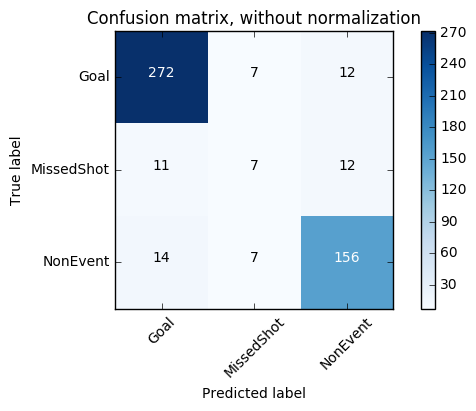

In [24]:
cnf_matrix = confusion_matrix(labels_test, test_predicted_labels)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Goal","MissedShot","NonEvent"],
                      title='Confusion matrix, without normalization')

In [25]:
event=[index
        for index,row in event_data.iterrows() 
        for i in np.arange(row["offset"],row["offset"]+row["timeToCapture"])]
second=[i-row["offset"]+1
        for index,row in event_data.iterrows() 
        for i in np.arange(row["offset"],row["offset"]+row["timeToCapture"])]
confused=index_test[(np.array(labels_test) == 'goal') & (np.array(test_predicted_labels) == 'nonevent')]
event=np.array(event)
second=np.array(second)

In [26]:
mixups=event_data.ix[event[confused]]
mixups["second"]=second[confused]
print("'secondOffset' is offset in the original clip")
print("'offset' is offset in the concatenated clip")
mixups

'secondOffset' is offset in the original clip
'offset' is offset in the concatenated clip


,fileName,secondOffset,eventName,timeToCapture,offset,second
47,mal_eng_2nd_half_eng.mp4,2871,goal,1,729,1
302,ROM-LAZ_2nd_half_ENG.mp4,482,goal,2,2331,2
154,BEL_MEX_2h_esp.mp4,583,goal,8,1614,1
278,stut_bvb_2nd_half_eng.mp4,375,goal,2,2221,2
159,bvb_bay_1st_half_eng.mp4,2268,goal,5,1645,1
179,JUV-BEN_1st_half_ENG.mp4,1295,goal,10,1734,8
295,NAP-MIL_2nd_half_ENG.mp4,2791,goal,3,2310,1
130,fue_rma_2nd_half_eng.mp4,1079,goal,3,1494,1
268,udi_juv_2nd_half_eng.mp4,124,goal,3,2170,1
188,mag_dor_2nd_half_eng.mp4,104,goal,5,1783,2


# Gradient Boosting Classifier

In [27]:
from sklearn.ensemble import GradientBoostingClassifier
gra = GradientBoostingClassifier()
gra.fit(data_train, labels_train)
joblib.dump(model, 'model_gra.pkl', protocol=2) 
print('Accuracy (GBC):', gra.score(data_test, labels_test))

Accuracy (GBC): 0.89156626506


In [28]:
test_predicted_labels_gra = gra.predict(data_test)
wrong_prediction_gra = (test_predicted_labels_gra != labels_test)
print('number of incorrect predictions: {0} out of {1}'.format(np.sum(wrong_prediction), len(labels_test)))


number of incorrect predictions: 63 out of 498


In [29]:
print('accuracy: {0:.3g}%'.format(100*float(np.sum((test_predicted_labels_gra == labels_test)))/len(labels_test)))
print("F1 score: {0:.3g}%".format(100*f1_score(labels_test, test_predicted_labels_gra, average="weighted")))
print("Precision: {0:.3g}%".format(100*precision_score(labels_test, test_predicted_labels_gra, average="weighted")))
print("Recall: : {0:.3g}%".format(100*recall_score(labels_test, test_predicted_labels_gra, average="weighted")))   

accuracy: 89.2%
F1 score: 87.2%
Precision: 88.4%
Recall: : 89.2%


# SVM Classifier

In [30]:
from sklearn import svm
from sklearn import datasets

model_svm = svm.SVC(C=100000)
model_svm.fit(data_train, labels_train)
joblib.dump(model_svm, 'model_svm.pkl', protocol=2) 
test_predicted_labels = model_svm.predict(data_test)
wrong_prediction = (test_predicted_labels != labels_test)
print('number of incorrect predictions: {0} out of {1}'.format(np.sum(wrong_prediction), len(labels_test)))

number of incorrect predictions: 60 out of 498


In [31]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print('accuracy: {0:.3g}%'.format(100*float(np.sum((test_predicted_labels == labels_test)))/len(labels_test)))
print("F1 score: {0:.3g}%".format(100*f1_score(labels_test, test_predicted_labels, average="weighted")))
print("Precision: {0:.3g}%".format(100*precision_score(labels_test, test_predicted_labels, average="weighted")))
print("Recall: : {0:.3g}%".format(100*recall_score(labels_test, test_predicted_labels, average="weighted")))

accuracy: 88%
F1 score: 85.8%
Precision: 85.9%
Recall: : 88%


## Random Forest

In [32]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 

rfc = RandomForestClassifier(n_estimators=200, max_features=100, bootstrap=True, oob_score=True, min_samples_leaf=2)
rfc.fit(data_train, labels_train)

print('Accuracy (a random forest):', rfc.score(data_test, labels_test))

Accuracy (a random forest): 0.867469879518


In [33]:
test_predicted_labels_rfc = rfc.predict(data_test)

wrong_prediction_rfc = (test_predicted_labels_rfc != labels_test)

print('number of incorrect predictions:', np.sum(wrong_prediction_rfc))

number of incorrect predictions: 66


In [34]:
print('accuracy: {0:.3g}%'.format(100*float(np.sum((test_predicted_labels_rfc == labels_test)))/len(labels_test)))
print("F1 score: {0:.3g}%".format(100*f1_score(labels_test, test_predicted_labels_rfc, average="weighted")))
print("Precision: {0:.3g}%".format(100*precision_score(labels_test, test_predicted_labels_rfc, average="weighted")))
print("Recall: : {0:.3g}%".format(100*recall_score(labels_test, test_predicted_labels_rfc, average="weighted")))  

accuracy: 86.7%
F1 score: 84.4%
Precision: 83.8%
Recall: : 86.7%


In [35]:
# cnf_matrix = confusion_matrix(labels_test, test_predicted_labels_rfc)
# np.set_printoptions(precision=2)

# # Plot non-normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=["Whistle","CardGiven","Goal","MissedShot","NonEvent"],
#                       title='Confusion matrix, without normalization')

## Voting Classifier (Ensemble)

In [36]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

clf1 = KNeighborsClassifier(n_neighbors=4)
clf2 = RandomForestClassifier(n_estimators=200, max_features=100, bootstrap=True, oob_score=True, min_samples_leaf=2)
clf3 = GradientBoostingClassifier()
clf4 = svm.SVC(C=100000)

eclf3 = VotingClassifier(estimators=[
       ('knn', clf1), ('rf', clf2), ('gbc', clf3), ('svm', clf3)],
       voting='soft', weights=[2,1,3,1])
eclf3 = eclf3.fit(data_train, labels_train)
print('Accuracy (ensemble):', eclf3.score(data_test, labels_test))

Accuracy (ensemble): 0.899598393574


In [37]:
joblib.dump(eclf3, 'model_ensemble.pkl', protocol=2) 
test_predicted_labels_eclf3 = eclf3.predict(data_test)
wrong_prediction_eclf3 = (test_predicted_labels_eclf3 != labels_test)
print('number of incorrect predictions: {0} out of {1}'.format(np.sum(wrong_prediction_eclf3), len(labels_test)))

number of incorrect predictions: 50 out of 498


In [38]:
print('accuracy: {0:.3g}%'.format(100*float(np.sum((test_predicted_labels_eclf3 == labels_test)))/len(labels_test)))
print("F1 score: {0:.3g}%".format(100*f1_score(labels_test, test_predicted_labels_eclf3, average="weighted")))
print("Precision: {0:.3g}%".format(100*precision_score(labels_test, test_predicted_labels_eclf3, average="weighted")))
print("Recall: : {0:.3g}%".format(100*recall_score(labels_test, test_predicted_labels_eclf3, average="weighted")))  

accuracy: 90%
F1 score: 88%
Precision: 88.4%
Recall: : 90%


In [39]:
event=[index
        for index,row in event_data.iterrows() 
        for i in np.arange(row["offset"],row["offset"]+row["timeToCapture"])]
second=[i-row["offset"]+1
        for index,row in event_data.iterrows() 
        for i in np.arange(row["offset"],row["offset"]+row["timeToCapture"])]
confused=index_test[(np.array(labels_test) == 'goal') & (np.array(test_predicted_labels_eclf3) == 'nonevent')]
event=np.array(event)
second=np.array(second)

In [40]:
mixups=event_data.ix[event[confused]]
mixups["second"]=second[confused]
print("'secondOffset' is offset in the original clip")
print("'offset' is offset in the concatenated clip")
mixups

'secondOffset' is offset in the original clip
'offset' is offset in the concatenated clip


,fileName,secondOffset,eventName,timeToCapture,offset,second
55,NAP_V_MCI_2H_ENG.mp4,1454,goal,4,840,1
302,ROM-LAZ_2nd_half_ENG.mp4,482,goal,2,2331,2
157,BEL_MEX_2h_esp.mp4,1493,goal,7,1635,7
278,stut_bvb_2nd_half_eng.mp4,375,goal,2,2221,2
226,por_usa_1st_half_eng.mp4,2016,goal,1,1983,1
219,RUS_V_ESP_1H_ESP.mp4,2256,goal,2,1943,2


Confusion matrix, without normalization
[[283   2   6]
 [ 16   3  11]
 [ 15   0 162]]


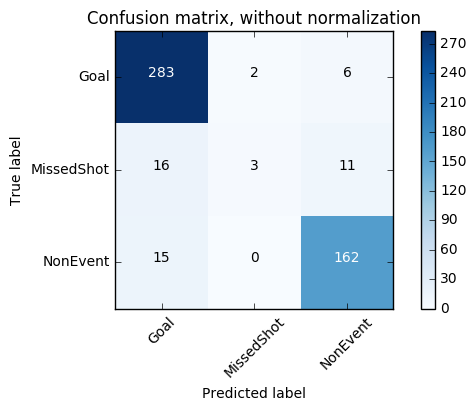

In [41]:
cnf_matrix = confusion_matrix(labels_test, test_predicted_labels_eclf3)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Goal","MissedShot","NonEvent"],
                      title='Confusion matrix, without normalization')

## Cross-Validation

In [42]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.linear_model import LogisticRegression
# from sklearn.naive_bayes import GaussianNB 
# from sklearn.ensemble import RandomForestClassifier
# from mlxtend.classifier import EnsembleVoteClassifier

# clf1 = LogisticRegression(random_state=1)
# clf2 = RandomForestClassifier(random_state=1)
# clf3 = GradientBoostingClassifier()
# eclf = EnsembleVoteClassifier(clfs=[clf1, clf2, clf3], voting='soft')

# params = {'logisticregression__C': [1.0, 100.0],
#           'randomforestclassifier__n_estimators': [20, 200, 500, 1000],}

# grid = GridSearchCV(estimator=eclf, param_grid=params, cv=5)
# grid.fit(data_train, labels_train)

# cv_keys = ('mean_test_score', 'std_test_score', 'params')

# for r, _ in enumerate(grid.cv_results_['mean_test_score']):
#     print("%0.3f +/- %0.2f %r"
#           % (grid.cv_results_[cv_keys[0]][r],
#              grid.cv_results_[cv_keys[1]][r] / 2.0,
#              grid.cv_results_[cv_keys[2]][r]))